# Blaseball ELO System
## By @BirdWife#7151 [@Birdwife_](https://www.twitter.com/BirdWife_)

Are Crabs Good? Let's find out using ddm7018's Elo implementation: https://github.com/ddm7018/Elo

In [353]:
# Imports and globals

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns=None
pd.options.display.max_rows=None

sns.set(rc={'axes.facecolor':'darkgray', 'figure.facecolor':'darkgray'})

#### Getting and saving our game data

In [2]:
req = requests.get(f'https://api.sibr.dev/chronicler/v1/games')

In [3]:
x = req.json()

In [4]:
games = pd.json_normalize(x['data'])

In [5]:
games.to_csv('./data/games.csv',index=False)

#### Exploring to ensure we have what we need

In [242]:
games.head()

,gameId,startTime,endTime,data.id,data.day,data.phase,data.rules,data.shame,data.inning,data.season,data.weather,data.awayOdds,data.awayTeam,data.homeOdds,data.homeTeam,data.outcomes,data.awayBases,data.awayScore,data.finalized,data.gameStart,data.homeBases,data.homeScore,data.statsheet,data.atBatBalls,data.awayBatter,data.homeBatter,data.lastUpdate,data.awayPitcher,data.awayStrikes,data.baseRunners,data.homePitcher,data.homeStrikes,data.seriesIndex,data.terminology,data.topOfInning,data.atBatStrikes,data.awayTeamName,data.gameComplete,data.homeTeamName,data.isPostseason,data.seriesLength,data.awayTeamColor,data.awayTeamEmoji,data.basesOccupied,data.homeTeamColor,data.homeTeamEmoji,data.awayBatterName,data.halfInningOuts,data.homeBatterName,data.awayPitcherName,data.baseRunnerNames,data.baserunnerCount,data.halfInningScore,data.homePitcherName,data.awayTeamNickname,data.homeTeamNickname,data.awayTeamBatterCount,data.homeTeamBatterCount,data._id,data.repeatCount,data.awayTeamSecondaryColor,data.homeTeamSecondaryColor,winner,loser
0,163ef59e-7be8-48cd-ae9e-eb45c70d28d4,2020-07-20T16:00:00Z,2020-07-20T16:00:00Z,163ef59e-7be8-48cd-ae9e-eb45c70d28d4,1,4,4ae9d46a-5408-460a-84fb-cbd8d03fff6c,False,8,1,1.0,0.381258,878c1bf6-0d21-4659-bfee-916c8314d69c,0.618742,b024e975-1c4a-4575-8936-a3754a08806a,[],4.0,6,True,True,4.0,2,6ca27ca4-e2d4-43d8-818e-c83462ee9608,0,None,None,Game over.,773712f6-d76d-4caa-8a9b-56fe1d1a5a68,3.0,[],b7ca8f3f-2fdc-477b-84f4-157f2802e9b5,3.0,1,b67e9bbb-1495-4e1b-b517-f1444b0a6c8b,False,0,Los Angeles Tacos,True,Dallas Steaks,False,3,#64376e,0x1F32E,[],#8c8d8f,0x1F969,None,0,None,Natha Kath,[],0,0,Leach Herman,Tacos,Steaks,37,36,NaN,NaN,NaN,NaN,Tacos,Steaks
1,2ac882ba-cd80-4af3-963c-f230c5309c66,2020-07-20T16:00:00Z,2020-07-20T16:00:00Z,2ac882ba-cd80-4af3-963c-f230c5309c66,1,4,4ae9d46a-5408-460a-84fb-cbd8d03fff6c,True,10,1,1.0,0.608380,747b8e4a-7e50-4638-a973-ea7950a3e739,0.391620,9debc64f-74b7-4ae1-a4d6-fce0144b6ea5,[],4.0,3,True,True,4.0,7,acbdb05a-d4bd-4de8-869c-2b661af1698f,0,c0732e36-3731-4f1a-abdc-daa9563b6506,None,Game over.,9abe02fb-2b5a-432f-b0af-176be6bd62cf,3.0,[],32551e28-3a40-47ae-aed1-ff5bc66be879,3.0,1,b67e9bbb-1495-4e1b-b517-f1444b0a6c8b,False,0,Hades Tigers,True,Houston Spies,False,3,#5c1c1c,0x1F405,[],#67556b,0x1F575,Nagomi Mcdaniel,0,None,Nagomi Meng,[],0,0,Math Velazquez,Tigers,Spies,38,43,NaN,NaN,NaN,NaN,Spies,Tigers
2,4cc78f38-36b7-4282-baa6-21ff46a41e56,2020-07-20T16:00:00Z,2020-07-20T16:00:00Z,4cc78f38-36b7-4282-baa6-21ff46a41e56,1,4,4ae9d46a-5408-460a-84fb-cbd8d03fff6c,False,8,1,1.0,0.583882,23e4cbc1-e9cd-47fa-a35b-bfa06f726cb7,0.416118,8d87c468-699a-47a8-b40d-cfb73a5660ad,[],4.0,3,True,True,4.0,7,effc1ef9-5213-412c-98cf-c1a0422c1cb3,0,None,None,Game over.,1732e623-ffc2-40f0-87ba-fdcf97131f1f,3.0,[],97dfc1f6-ac94-4cdc-b0d5-1cb9f8984aa5,3.0,1,b67e9bbb-1495-4e1b-b517-f1444b0a6c8b,True,0,Philly Pies,True,Baltimore Crabs,False,3,#399d8f,0x1F967,[],#593037,0x1F980,None,0,None,Betsy Trombone,[],0,0,Brock Forbes,Pies,Crabs,33,33,NaN,NaN,NaN,NaN,Crabs,Pies
3,50a936f5-94ec-4668-b225-d4a37c6d4e07,2020-07-20T16:00:00Z,2020-07-20T16:00:00Z,50a936f5-94ec-4668-b225-d4a37c6d4e07,1,4,4ae9d46a-5408-460a-84fb-cbd8d03fff6c,False,8,1,1.0,0.488910,979aee4a-6d80-4863-bf1c-ee1a78e06024,0.511090,b72f3061-f573-40d7-832a-5ad475bd7909,[],4.0,5,True,True,4.0,8,1032bd08-0f03-49b9-8113-eeec0f160c23,0,None,None,Game over.,7b55d484-6ea9-4670-8145-986cb9e32412,3.0,[],7c5ae357-e079-4427-a90f-97d164c7262e,3.0,1,b67e9bbb-1495-4e1b-b517-f1444b0a6c8b,True,0,Hawaii Fridays,True,San Francisco Lovers,False,3,#3ee652,0x1F3DD,[],#780018,0x1F48B,None,0,None,Stevenson Heat,[],0,0,Milo Brown,Fridays,Lovers,42,34,NaN,NaN,NaN,NaN,Lovers,Fridays
4,722b4012-f4d5-4393-8219-8b5fbc0cde8a,2020-07-20T16:00:00Z,2020-07-20T16:00:00Z,722b4012-f4d5-4393-8219-8b5fbc0cde8a,1,4,4ae9d46a-5408-460a-84fb-cbd8d03fff6c,False,8,1,1.0,0.368800,adc5b394-8f76-416d-9ce9-813706877b84,0.631200,3f8bbb15-61c0-4e3f-8e4a-907a5fb1565e,[],4.0,3,True,True,4.0,5,70c69b58

#### Create an outcome flag and some cleaning to make things easier

In [69]:
# Outcome flags and nickname cleaning
games['data.awayTeamNickname'] = games['data.awayTeamNickname'].map(lambda x: 'Dale' if x == 'Dalé' else 'Wild Wings' if x == 'Mild Wings' else x)
games['data.homeTeamNickname'] = games['data.homeTeamNickname'].map(lambda x: 'Dale' if x == 'Dalé' else 'Wild Wings' if x == 'Mild Wings' else x)

winner = []
loser = []
for index, entry in games.iterrows():
    winner.append(entry['data.awayTeamNickname'] if entry['data.awayScore'] > entry['data.homeScore'] else entry['data.homeTeamNickname'])
    loser.append(entry['data.awayTeamNickname'] if entry['data.awayScore'] < entry['data.homeScore'] else entry['data.homeTeamNickname'])


games['winner'] = winner
games['loser'] = loser

# Incrementing day and season up 1 for clarity
games['data.day'] = games['data.day'].map(lambda x: x + 1)
games['data.season'] = games['data.season'].map(lambda x: x + 1)

In [45]:
games['winner'].value_counts()

Tigers           632
Crabs            629
Pies             564
Shoe Thieves     558
Jazz Hands       544
Steaks           543
Moist Talkers    534
Millennials      533
Garages          528
Firefighters     528
Spies            512
Lovers           511
Breath Mints     486
Flowers          478
Wild Wings       470
Magic            455
Sunbeams         437
Dale             433
Fridays          402
Tacos            369
Name: winner, dtype: int64

In [46]:
games['loser'].value_counts()

Tacos            634
Fridays          598
Sunbeams         562
Magic            551
Flowers          544
Dale             542
Wild Wings       527
Lovers           517
Spies            504
Firefighters     500
Breath Mints     496
Jazz Hands       489
Moist Talkers    487
Garages          481
Millennials      480
Shoe Thieves     479
Pies             477
Steaks           473
Tigers           415
Crabs            390
Name: loser, dtype: int64

#### Creating Elo Table

In [346]:
color_table = list(zip(games['data.homeTeamNickname'], games['data.homeTeamColor']))
color_table = list(set(color_table))
color_table.sort()
colors = [j for i, j in color_table]

team_colors = sns.set_palette(sns.color_palette(colors))

In [302]:
teams = list(games['winner'].unique())
teams.sort()

elo_table = {
    'season' : [-1],
    'day' : [-1],
    'is_postseason' : [False]
}

for team in teams:
    elo_table[team] = [1400]

elo_table = pd.DataFrame(elo_table)
elo_table

,season,day,is_postseason,Breath Mints,Crabs,Dale,Firefighters,Flowers,Fridays,Garages,Jazz Hands,Lovers,Magic,Millennials,Moist Talkers,Pies,Shoe Thieves,Spies,Steaks,Sunbeams,Tacos,Tigers,Wild Wings
0,-1,-1,False,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400,1400


#### Elo Update Formula

In [303]:
def update_elo(home_team_elo, home_team_score, away_team_elo, away_team_score, k=40, c = 200):
    new_home_team_elo = home_team_elo + (k/2) * (home_team_score - away_team_score + ((away_team_elo - home_team_elo)/(2*c)))
    new_away_team_elo = away_team_elo + (k/2) * (away_team_score - home_team_score + ((home_team_elo - away_team_elo)/(2*c)))
    return new_home_team_elo, new_away_team_elo

In [307]:
def update_elo_table(games = games, elo_table = elo_table):
    current_season = 0
    current_day = 0
    is_postseason = False
    date_index = 0
    for index, game in games.iterrows():
        ## TODO: Implement seasonal reset
        if game['data.season'] != current_season and current_season != 0:
            seasonal_reset_elos = [game['data.season'],0,False]
            
            for col in elo_table.columns[3:]:
                seasonal_reset_elos.append(elo_table.loc[date_index,col]/2 + 200)
            
            seasonal_reset_elos = pd.Series(seasonal_reset_elos,index=elo_table.columns)
            elo_table = elo_table.append(seasonal_reset_elos, ignore_index=True)
            elo_table.reset_index(inplace=True, drop=True)
            
            date_index += 1
            
        if game['data.awayScore'] == 0 and game['data.homeScore'] == 0:
            return(elo_table)
        # If we've entered a new day, add a row
        if game['data.season'] != current_season or game['data.day'] != current_day or game['data.isPostseason'] != is_postseason:
            
            current_season = game['data.season']
            current_day = game['data.day']
            is_postseason = game['data.isPostseason']
            date_index += 1
            
            # Copy the previous row first to ensure we don't introduce NaNs during playoffs
            elo_table = elo_table.append(elo_table.iloc[date_index-1,0:23])
            elo_table.reset_index(inplace=True, drop=True)
            
            elo_table.loc[date_index, 'season'] = current_season
            elo_table.loc[date_index, 'day'] = current_day
            elo_table.loc[date_index, 'is_postseason'] = is_postseason
            
        # Now make our elo table updates
        home_team = game['data.homeTeamNickname']
        away_team = game['data.awayTeamNickname']
        
        elo_table.loc[date_index, home_team], elo_table.loc[date_index, away_team] = update_elo(elo_table.loc[date_index-1,home_team],
                                                                game['data.homeScore'],
                                                                elo_table.loc[date_index-1,away_team],
                                                                game['data.awayScore'])
        
    return elo_table
            
            
        

In [308]:
new_elo_table = update_elo_table()

In [309]:
new_elo_table.tail(150)

,season,day,is_postseason,Breath Mints,Crabs,Dale,Firefighters,Flowers,Fridays,Garages,Jazz Hands,Lovers,Magic,Millennials,Moist Talkers,Pies,Shoe Thieves,Spies,Steaks,Sunbeams,Tacos,Tigers,Wild Wings
943,9,41,False,318.778986,1784.290088,315.328878,327.216552,460.722973,-740.188540,1284.173648,217.253630,24.849749,-157.257717,319.344407,252.175634,570.204573,721.224636,1005.004249,246.381911,220.010061,6.328989,768.919357,133.362938
944,9,42,False,275.448818,1806.076086,302.598582,337.523872,473.453268,-610.860017,1278.410934,116.641161,43.923711,-173.333599,351.887415,295.505801,537.661564,737.300518,1105.616718,117.053388,198.224062,-12.744973,774.682072,123.055619
945,9,43,False,308.559456,1672.648475,349.664839,470.951482,435.933385,-602.722646,1300.343056,80.720306,-3.142546,-247.801893,343.750044,199.464615,504.550927,811.768812,1149.698634,95.121266,234.144917,-56.826888,870.723258,160.575501
946,9,44,False,298.359029,1632.563626,192.024470,511.036332,642.165491,-655.399011,1220.081967,148.391536,154.497823,-134.823358,396.426409,133.027547,514.751353,698.790277,1129.372357,175.382355,166.473686,-36.500612,937.160326,-45.656605
947,9,45,False,289.178646,1456.487261,10.148137,687.112697,587.774386,-562.807740,1147.846986,129.295644,336.374156,-133.142676,303.835138,153.234186,523.931737,697.109595,1211.078709,247.617336,185.569579,-118.206964,916.953687,8.734500
948,9,46,False,260.567398,1578.018533,-17.016403,565.581425,652.475319,-557.275004,1142.314250,23.267587,300.109383,-105.978136,343.498861,94.850956,590.116017,657.445872,1247.343481,181.433056,243.952809,-182.907896,945.564935,114.762557
949,9,47,False,254.817274,1587.396677,38.535510,556.203280,670.706158,-632.295541,1217.334787,147.842335,327.471088,-161.530049,439.196212,22.306048,469.681869,561.748522,1219.981776,301.867204,316.497717,-201.138735,951.315058,-9.812191
950,9,48,False,269.642164,1635.837008,68.532232,507.762950,667.113913,-619.814025,1204.853271,179.959609,332.096623,-191.526771,465.323827,-42.984368,541.291136,535.620906,1215.356242,230.257937,381.788133,-197.546491,936.490169,-41.929465
951,9,49,False,182.941101,1487.400853,-35.804973,600.278329,815.550068,-601.758767,1231.435116,107.566460,404.489772,-224.099651,333.570533,-10.411488,523.235878,622.321969,944.711105,362.011232,486.125338,73.098646,909.908324,-134.444844
952,9,50,False,124.910144,1533.808314,-49.708457,643.542171,769.142607,-565.509035,1195.358776,182.412625,329.643606,-273.415243,234.992568,38.904104,486.986146,680.352926,881.130482,460.589197,500.028823,136.679269,945.984664,-177.708686


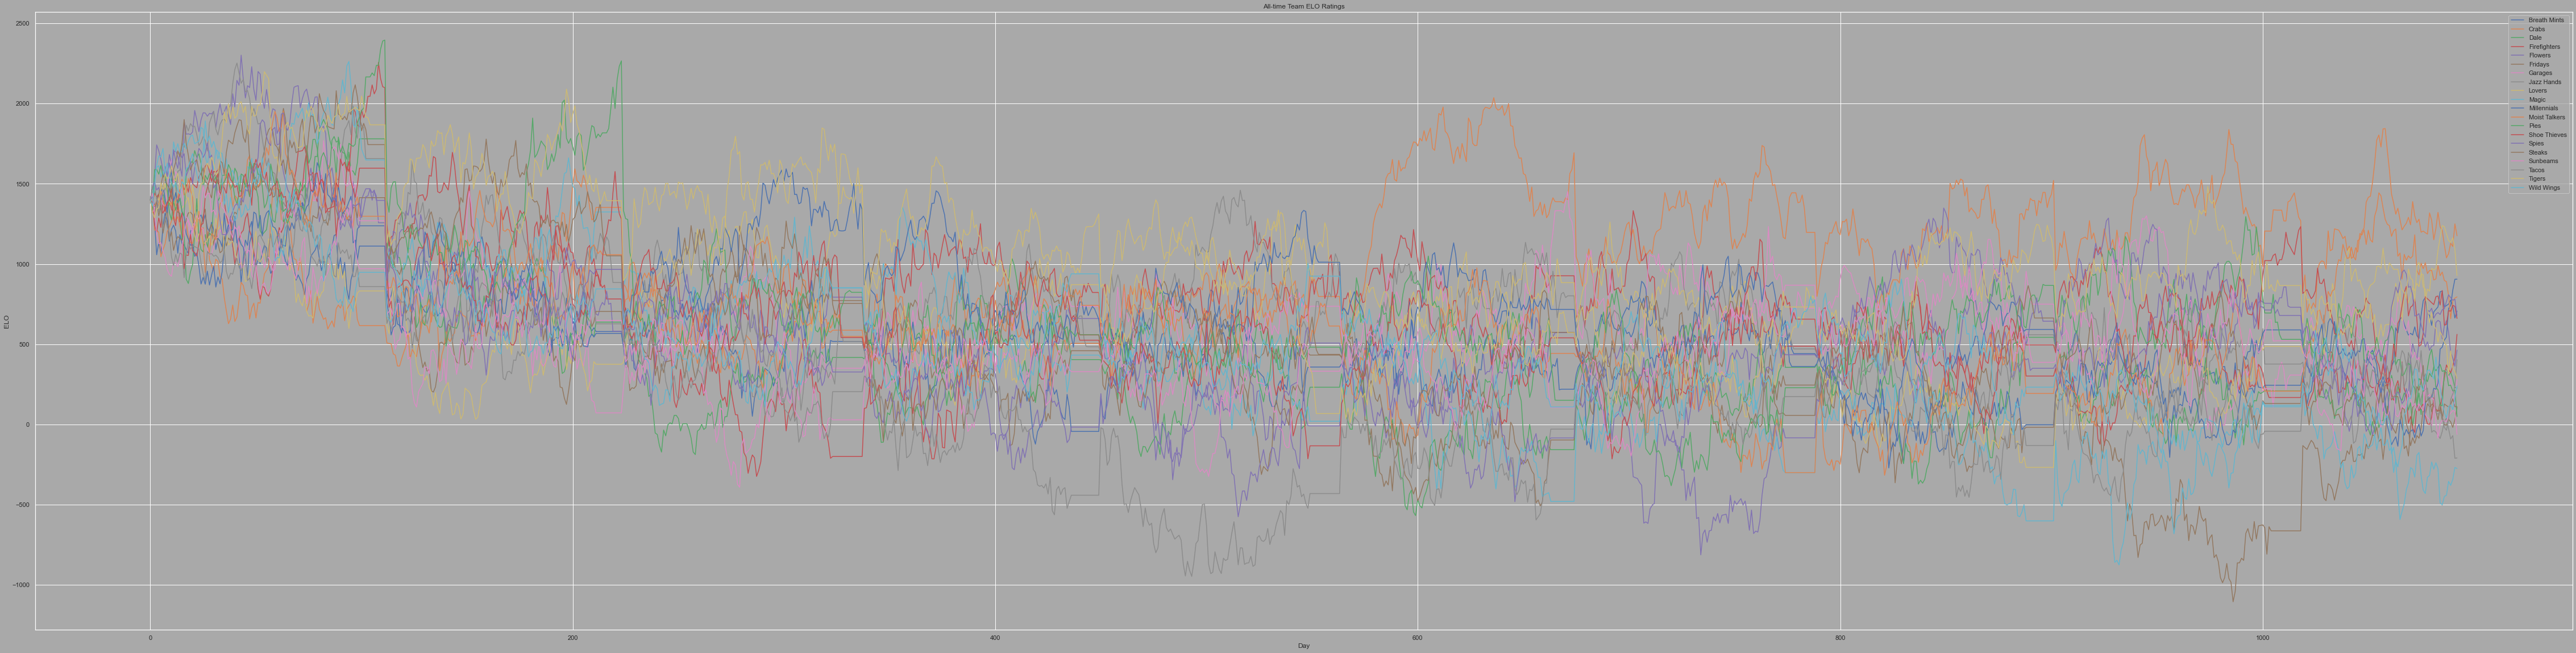

In [354]:
plt.figure(figsize=(80,20))
for i, team in enumerate(teams):
    sns.lineplot(x=new_elo_table.index, y=new_elo_table[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('All-time Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

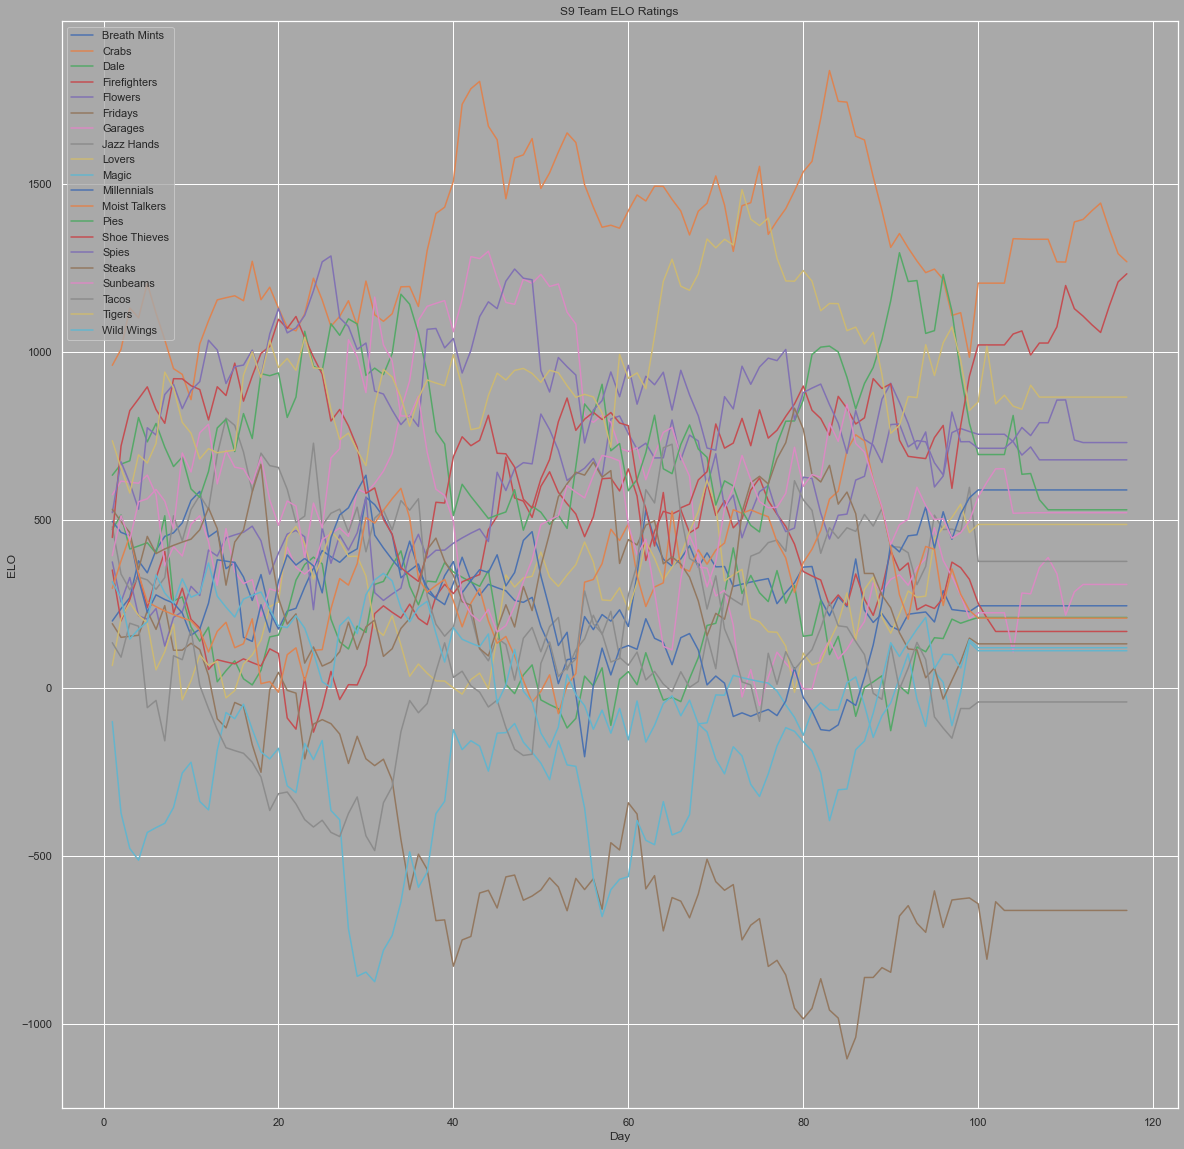

In [355]:
s9_elo = new_elo_table[new_elo_table['season'] == 9]
s9_elo.reset_index(inplace=True,drop=True)
s9_elo.index += 1

plt.figure(figsize=(20,20))
for i, team in enumerate(teams):
    sns.lineplot(x=s9_elo.index, y=s9_elo[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('S9 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

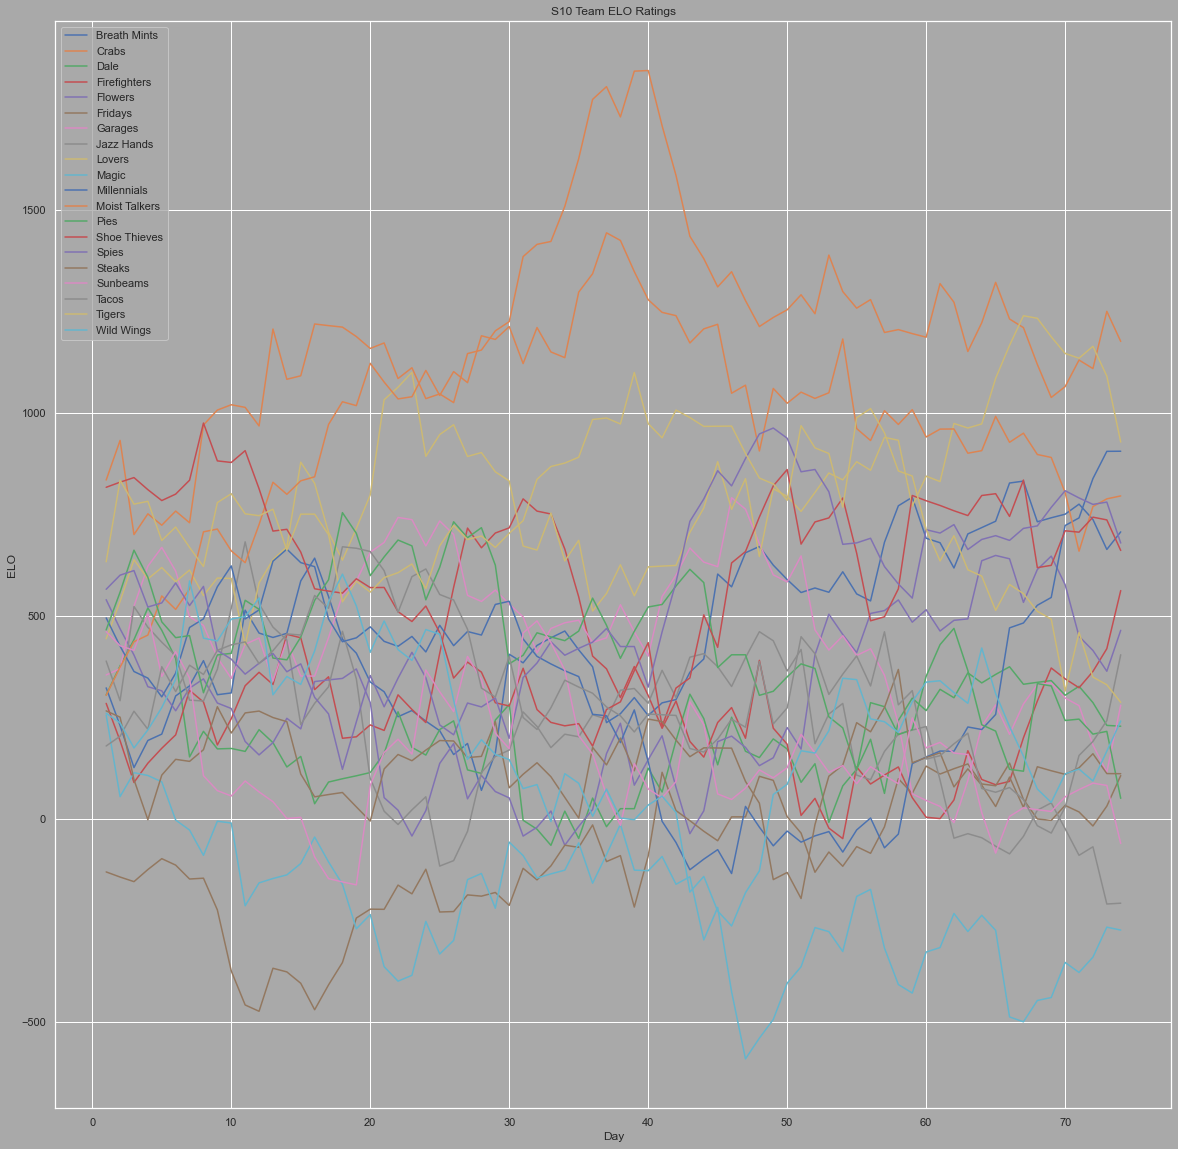

In [356]:
s10_elo = new_elo_table[new_elo_table['season'] == 10]
s10_elo.reset_index(inplace=True,drop=True)
s10_elo.index += 1

plt.figure(figsize=(20,20))
for i, team in enumerate(teams):
    sns.lineplot(x=s10_elo.index, y=s10_elo[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('S10 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

In [284]:
print(list(enumerate(teams)))

[(0, 'Breath Mints'), (1, 'Crabs'), (2, 'Dale'), (3, 'Firefighters'), (4, 'Flowers'), (5, 'Fridays'), (6, 'Garages'), (7, 'Jazz Hands'), (8, 'Lovers'), (9, 'Magic'), (10, 'Millennials'), (11, 'Moist Talkers'), (12, 'Pies'), (13, 'Shoe Thieves'), (14, 'Spies'), (15, 'Steaks'), (16, 'Sunbeams'), (17, 'Tacos'), (18, 'Tigers'), (19, 'Wild Wings')]


In [ ]:
new_elo_table.iloc[]

A player's new rating after a tournament is calculated :

Rn = Ro + (K/2)(W - L + (Sum of rating differences/2C))
Rn is the new rating, Ro is the old rating. W and L are the number of wins and losses. A rating difference is the opponent's rating minus the player's rating, not the other way around.

C will determine how spaced out the ratings are, i.e. the standard deviation. It appears that 200 is commonly used.

K will determine how much of an effect each game has. FIDE uses 30, and 20 once a player reaches IM. http://www.fide.com/component/content/article/1-fide-news/3963-rating-regulations-the-k-factor

A draw is 0 wins and 0 losses.


Elo devised a linear approximation to his full system. With that method, a player's new rating is

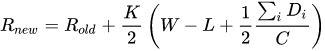

where Rnew and Rold are the player's new and old rating respectively, Di is the opponent's rating minus the player's rating, W is the number of wins, L is the number of losses, C = 200 and K = 32.

